# Machine Fault Classification with MAFAULDA

This notebook explores data from [MAFAULDA](https://www02.smt.ufrj.br/~offshore/mfs/page_01.html) which is a multivariate time-series dataset acquired by sensors on Machinery Fault Simulator (MFS) Alignment-Balance-Vibration (ABVT). Data from [Kaggle](https://www.kaggle.com/datasets/uysalserkan/fault-induction-motor-dataset/data) includes two different simulated states: normal function and imbalance fault. 

The objective is to build a time-series classification model to distinguish between normal and imbalance motor condition.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Data are stored in CSV files and saved in a label-based folder structure

In [1]:
!tree ../data/. -L 3 -I "*.csv"

../data/.
├── imbalance
│   └── imbalance
│       ├── 10g
│       ├── 15g
│       ├── 20g
│       ├── 25g
│       ├── 30g
│       ├── 35g
│       └── 6g
└── normal
    └── normal

12 directories, 0 files


#### From the folder structure we can extract the labels

In [2]:
import os

labels = []
for dirname, _, filenames in os.walk("../data"):
    for filename in filenames:
        file_addr = os.path.join(dirname, filename)
        class_name = "-".join(file_addr.split('.csv')[0].split("/")[-3:-1])
        labels.append(class_name)

print(set(labels))

{'imbalance-6g', 'imbalance-10g', 'imbalance-25g', 'imbalance-35g', 'imbalance-20g', 'normal-normal', 'imbalance-15g', 'imbalance-30g'}


## Data Frame

According with their website:
- There are 8 features: 'tachometer', 'underhang_axial', 'underhang_radiale', 'underhang_tangential', 'overhang_axial', 'overhang_radiale', 'overhang_tangential', 'microphone'.
- Each sequence was generated at 50 kHz sampling rate during 5 s, totaling 250.000 samples.

Let's instanciate and concatenate all dataframes that belongs to normal functioning label.

In [3]:
import os
import pandas as pd

col_names = [
    'tachometer', 'underhang_axial', 'underhang_radiale', 'underhang_tangential',
    'overhang_axial', 'overhang_radiale', 'overhang_tangential', 'microphone'
]

normal_dfs = []
for dirname, _, filenames in os.walk("../data"):
    # To make sure our data frames are aligned according with filename
    filenames = sorted(filenames, key=lambda f: float(f.replace('.csv', '')))
    for filename in filenames:
        file_addr = os.path.join(dirname, filename)
        if file_addr.endswith('.csv'):
            # Infer labels from folder structure
            label = "-".join(file_addr.split('.csv')[0].split("/")[-3:-1])

            if "normal" in label:
                print(file_addr)
                df = pd.read_csv(file_addr, names=col_names)
                normal_dfs.append(df)

print([f"{df.shape}" for df in normal_dfs])

../data/normal/normal/12.288.csv
../data/normal/normal/13.1072.csv
../data/normal/normal/14.336.csv
../data/normal/normal/15.1552.csv
../data/normal/normal/16.1792.csv
../data/normal/normal/17.2032.csv
../data/normal/normal/18.432.csv
../data/normal/normal/19.6608.csv
../data/normal/normal/20.2752.csv
../data/normal/normal/21.7088.csv
../data/normal/normal/22.3232.csv
../data/normal/normal/23.552.csv
../data/normal/normal/24.576.csv
../data/normal/normal/25.6.csv
../data/normal/normal/26.624.csv
../data/normal/normal/27.4432.csv
../data/normal/normal/28.8768.csv
../data/normal/normal/29.4912.csv
../data/normal/normal/30.72.csv
../data/normal/normal/31.744.csv
../data/normal/normal/32.9728.csv
../data/normal/normal/33.5872.csv
../data/normal/normal/34.2016.csv
../data/normal/normal/35.4304.csv
../data/normal/normal/36.4544.csv
../data/normal/normal/37.6832.csv
../data/normal/normal/38.2976.csv
../data/normal/normal/39.3216.csv
../data/normal/normal/40.3456.csv
../data/normal/normal/41.7

In [4]:
normal_df = pd.concat(normal_dfs, ignore_index=True)

normal_df.describe()

,tachometer,underhang_axial,underhang_radiale,underhang_tangential,overhang_axial,overhang_radiale,overhang_tangential,microphone
count,1.225000e+07,1.225000e+07,1.225000e+07,1.225000e+07,1.225000e+07,1.225000e+07,1.225000e+07,1.225000e+07
mean,1.565263e-04,7.892067e-03,-4.660431e-04,3.732063e-04,1.483657e-02,3.021278e-03,1.877392e-02,1.227750e-02
std,1.711226e+00,8.536628e-01,4.174455e-01,1.837692e-01,6.248925e-01,3.479750e-02,4.133592e-01,1.755920e-01
min,-1.558800e+00,-4.483500e+00,-3.417000e+00,-2.171700e+00,-2.956600e+00,-3.733500e-01,-2.865800e+00,-3.369100e+00
25%,-7.135100e-01,-5.590000e-01,-2.866900e-01,-8.650100e-02,-3.302000e-01,-2.157700e-02,-2.295400e-01,-1.245400e-01
50%,-6.491500e-01,7.351000e-02,1.331900e-02,8.434800e-04,2.170600e-02,4.061300e-03,1.297300e-02,-6.496600e-03
75%,-5.384100e-01,6.521300e-01,2.979900e-01,8.529200e-02,3.465300e-01,2.810800e-02,2.617800e-01,1.332000e-01
max,5.107800e+00,2.367200e+00,4.099800e+00,1.933000e+00,3.508700e+00,2.812800e-01,2.836000e+00,8.529000e-01


**Large file, could be beneficial to downsampling**

In [5]:
normal_df.head()

,tachometer,underhang_axial,underhang_radiale,underhang_tangential,overhang_axial,overhang_radiale,overhang_tangential,microphone
0,4.5595,0.175200,0.287210,-0.017751,-0.41565,0.032459,-0.11218,-0.128140
1,4.6038,-0.051295,-0.194050,-0.060071,-0.41809,0.036547,-0.11043,0.118310
2,4.5703,-0.969080,0.038033,-0.028329,-0.43081,0.041924,-0.14331,-0.071527
3,4.5870,0.891270,0.072973,0.007453,-0.40017,0.041090,-0.11984,0.043445
4,4.5887,-1.716000,-0.329290,-0.033063,-0.50281,0.040474,-0.25270,0.023901


In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(normal_df, title="Normal Data")
profile.to_file("normal_data_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

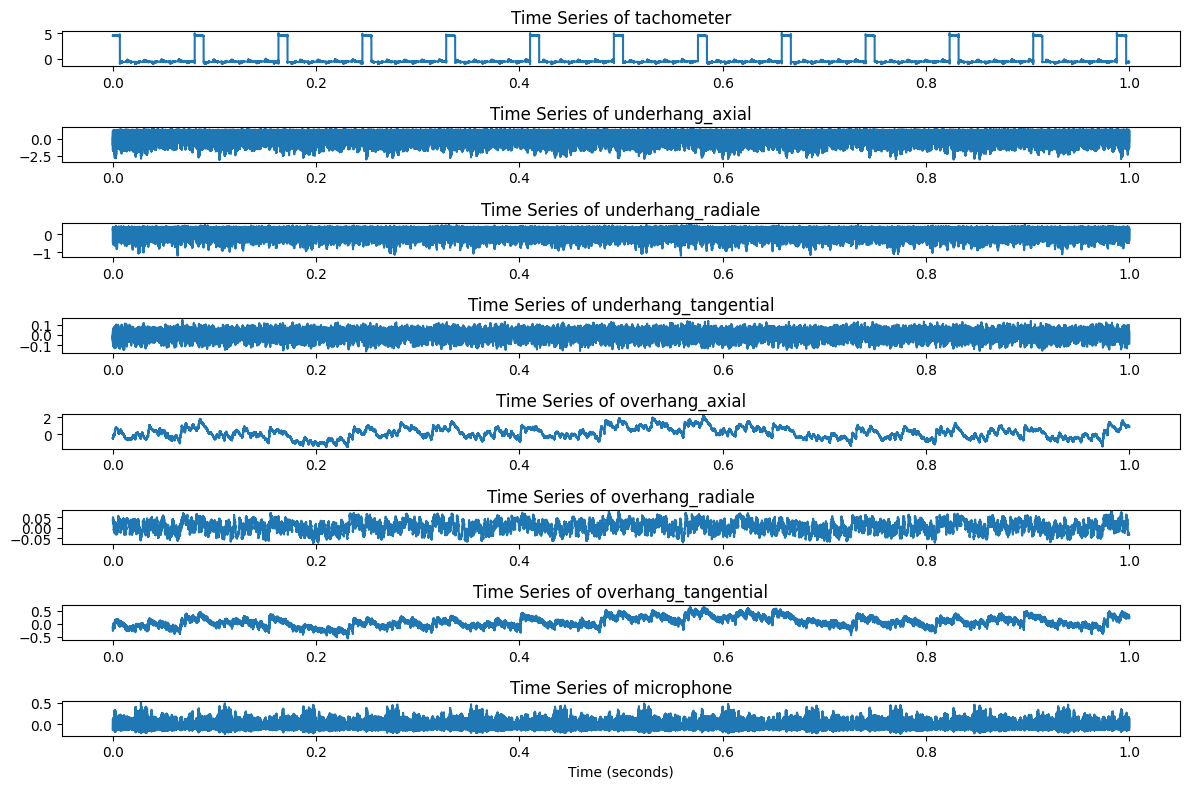

In [12]:
import matplotlib.pyplot as plt

import numpy as np

def add_elapsed_time(df, sampling_rate=50_000):
    """
    Adds a 'time' column to the DataFrame based on the sampling_rate.
    Assumes each row is one sample and data is continuous.
    """
    n_samples = len(df)
    time_values = np.arange(n_samples) / sampling_rate  # in seconds
    df['time'] = time_values
    return df


def plot_timeseries(df, columns, n_samples=50000):
    """
    Plots selected time-series columns from a DataFrame over n_samples, using the 'time' column for the x-axis.
    """
    plt.figure(figsize=(12, len(columns)))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns), 1, i)
        plt.plot(df['time'][:n_samples], df[col].values[:n_samples])  # Use 'time' column as x-axis
        if i == len(columns):
            plt.xlabel("Time (seconds)")
        plt.title(f"Time Series of {col}")
        plt.tight_layout()
    plt.show()

normal_df = add_elapsed_time(normal_df)

plot_timeseries(normal_df, columns=normal_df.columns.drop('time'))

## Load imbalance 6g data

In [2]:
def load_filtered_dfs(data_path, filter_label):
    """
    Loads CSV files from a directory structure and filters them based on labels.
        
    Returns:
    - List of DataFrames that match the filter criteria.
    """
    col_names = [
        'tachometer', 'underhang_axial', 'underhang_radiale', 'underhang_tangential',
        'overhang_axial', 'overhang_radiale', 'overhang_tangential', 'microphone'
    ]

    filtered_dfs = []
    
    for dirname, _, filenames in os.walk(data_path):
        # Ensure filenames are sorted numerically
        filenames = sorted(filenames, key=lambda f: float(f.replace('.csv', '')))
        
        for filename in filenames:
            file_addr = os.path.join(dirname, filename)
            
            if file_addr.endswith('.csv'):
                # Extract label from folder structure
                label = "-".join(file_addr.split('.csv')[0].split("/")[-3:-1])
                
                # Check if any of the filter labels are in the extracted label
                if filter_label in label:
                    print(f"Loading: {file_addr}")
                    df = pd.read_csv(file_addr, names=col_names)
                    filtered_dfs.append(df)
    
    return filtered_dfs

data_path = "../data"
filter_label = "imbalance-6g"

imbalance_dfs = load_filtered_dfs(data_path, filter_label)

print([f"{df.shape}" for df in imbalance_dfs])

Loading: ../data/imbalance/imbalance/6g/13.9264.csv
Loading: ../data/imbalance/imbalance/6g/14.336.csv
Loading: ../data/imbalance/imbalance/6g/15.36.csv
Loading: ../data/imbalance/imbalance/6g/16.1792.csv
Loading: ../data/imbalance/imbalance/6g/17.408.csv
Loading: ../data/imbalance/imbalance/6g/18.432.csv
Loading: ../data/imbalance/imbalance/6g/19.6608.csv
Loading: ../data/imbalance/imbalance/6g/20.2752.csv
Loading: ../data/imbalance/imbalance/6g/21.7088.csv
Loading: ../data/imbalance/imbalance/6g/22.7328.csv
Loading: ../data/imbalance/imbalance/6g/23.552.csv
Loading: ../data/imbalance/imbalance/6g/24.576.csv
Loading: ../data/imbalance/imbalance/6g/25.3952.csv
Loading: ../data/imbalance/imbalance/6g/26.8288.csv
Loading: ../data/imbalance/imbalance/6g/27.648.csv
Loading: ../data/imbalance/imbalance/6g/28.8768.csv
Loading: ../data/imbalance/imbalance/6g/29.4912.csv
Loading: ../data/imbalance/imbalance/6g/30.5152.csv
Loading: ../data/imbalance/imbalance/6g/31.5392.csv
Loading: ../data/imb

In [3]:
imbalance_df = pd.concat(imbalance_dfs, ignore_index=True)

imbalance_df.describe()

,tachometer,underhang_axial,underhang_radiale,underhang_tangential,overhang_axial,overhang_radiale,overhang_tangential,microphone
count,1.225000e+07,1.225000e+07,1.225000e+07,1.225000e+07,1.225000e+07,1.225000e+07,1.225000e+07,1.225000e+07
mean,-1.712867e-06,3.055806e-03,2.694678e-04,9.066296e-04,7.706909e-03,3.113166e-03,4.595731e-02,1.402789e-02
std,1.723980e+00,8.341692e-01,5.183670e-01,2.193339e-01,1.063280e-01,3.006839e-02,7.105123e-01,1.809850e-01
min,-1.548600e+00,-4.508500e+00,-3.710500e+00,-2.390600e+00,-7.665000e-01,-1.563800e-01,-5.026500e+00,-4.824000e-01
25%,-7.294600e-01,-5.393200e-01,-3.292700e-01,-1.056400e-01,-5.231200e-02,-1.847100e-02,-3.835600e-01,-1.289900e-01
50%,-6.578300e-01,6.408900e-02,4.550700e-03,-3.003800e-03,1.464100e-02,3.695500e-03,4.084400e-02,-5.352700e-03
75%,-5.484000e-01,6.245200e-01,3.209000e-01,9.373800e-02,7.487700e-02,2.539900e-02,4.687900e-01,1.399700e-01
max,5.113000e+00,2.409900e+00,5.384100e+00,2.713400e+00,5.508300e-01,1.392800e-01,4.442600e+00,8.686900e-01


In [4]:
imbalance_df.head()

,tachometer,underhang_axial,underhang_radiale,underhang_tangential,overhang_axial,overhang_radiale,overhang_tangential,microphone
0,-0.59640,1.65690,0.20359,0.048174,-0.18477,-0.021301,-0.18447,-0.017205
1,-0.52322,-0.28902,-0.31740,-0.001450,-0.19779,-0.023694,-0.28712,-0.018203
2,-0.55320,1.64770,0.41715,0.038655,-0.18563,-0.021564,-0.21215,-0.072039
3,-0.57723,0.15914,-0.33321,-0.011148,-0.19892,-0.025401,-0.30076,-0.007373
4,-0.49280,1.31650,0.41147,0.028096,-0.19165,-0.022879,-0.24147,-0.108590


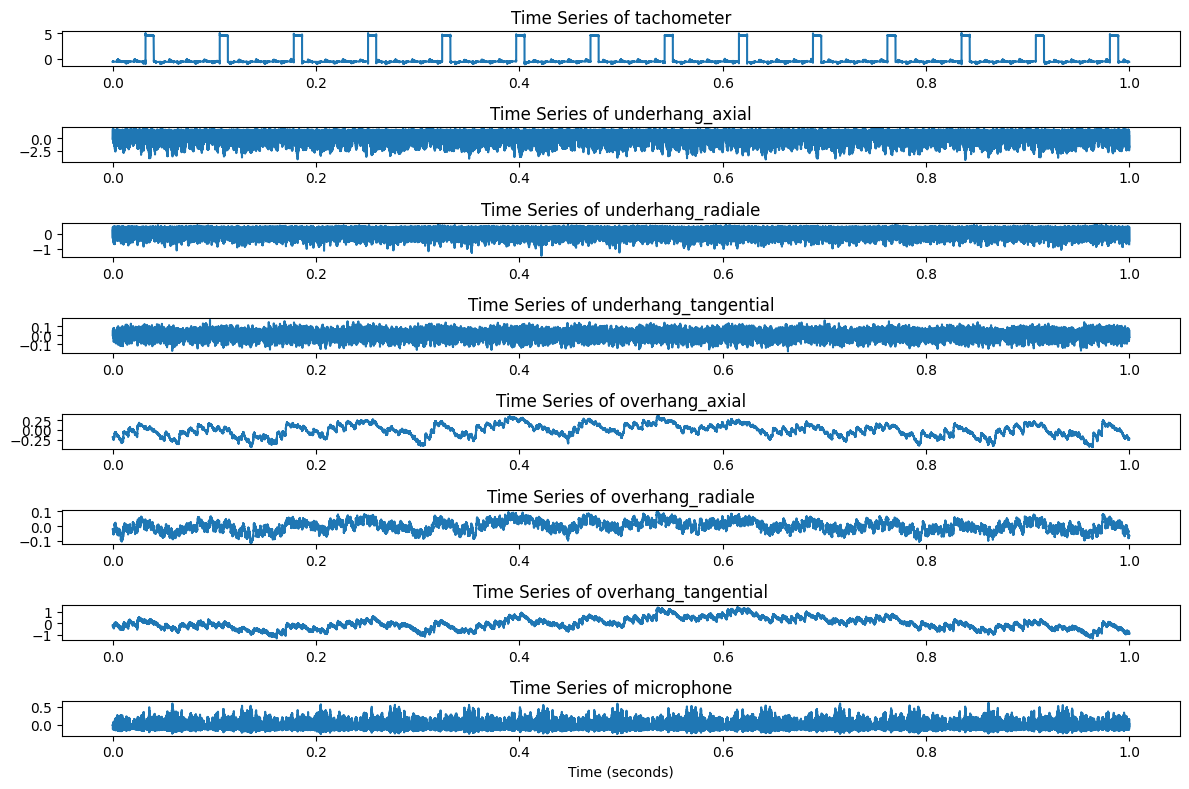

In [6]:
import matplotlib.pyplot as plt

import numpy as np

def add_elapsed_time(df, sampling_rate=50_000):
    """
    Adds a 'time' column to the DataFrame based on the sampling_rate.
    Assumes each row is one sample and data is continuous.
    """
    n_samples = len(df)
    time_values = np.arange(n_samples) / sampling_rate  # in seconds
    df['time'] = time_values
    return df


def plot_timeseries(df, columns, n_samples=50000):
    """
    Plots selected time-series columns from a DataFrame over n_samples, using the 'time' column for the x-axis.
    """
    plt.figure(figsize=(12, len(columns)))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns), 1, i)
        plt.plot(df['time'][:n_samples], df[col].values[:n_samples])  # Use 'time' column as x-axis
        if i == len(columns):
            plt.xlabel("Time (seconds)")
        plt.title(f"Time Series of {col}")
        plt.tight_layout()
    plt.show()

imbalance_df = add_elapsed_time(imbalance_df)

plot_timeseries(imbalance_df, columns=imbalance_df.columns.drop('time'))